![](images/obspy_logo_full_524x179px.png)

<div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">Breve guida a ObsPy: Python per la sismologia</div>


Questa guida trae spunto dal Tutorial di:

* Lion Krischer ([@krischer](https://github.com/krischer))
* Tobias Megies ([@megies](https://github.com/megies))

Seismo-Live: http://seismo-live.org

---

**Questa guida si propone di illustrare le funzioni e le classi di ObsPy**

In sismologia possiamo distinguere 3 tipi fondamentali di dati e ciascuno di essi viene letto da una funzione in ObsPy:
* `obspy.read()`: legge le forme d'onda dagli oggetti `obspy.Stream` e `obspy.Trace`.
* `obspy.read_inventory()`: legge le informazioni sulle stazioni dagli oggetti `obspy.Inventory`.
* `obspy.read_events()`: legge gli eventi dagli oggetti `obspy.Catalog`.

Il formato specifico di ciascuno di questi tipi di dato viene determinato automaticamente da ObsPy, ciascuna funzione supporta la lettura da URL, vari formati di compressione, file in memoria e altre fonti. Molti formati di file sono disponibili anche in scrittura. Gli oggetti risultanti consentono la manipolazione dei dati in vari modi.

Uno degli obiettivi principali di ObsPy è quello di evitare che i ricercatori si debbano preoccupare del formato in cui i loro dati sono scritti per concentrarsi esclusivamente sul compito da svolgere.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 24, 16

## FDSN/SEED Identificatori

In accordo allo [standard SEED](http://www.fdsn.org/media/_s/publications/SEEDManual_V2.4.pdf), la nomenclatura che segue viene usata per identificare ricevitori sismici:

* **Network identifier**: Identifica la rete/proprietà dei dati. È assegnata dalla FDSN ed è quindi unica.
* **Station identifier**: Identifica la stazione all'interno della rete. *NON È UNICA. Va sempre usata insieme al codice della rete!*
* **Location identifer**: Identifica differenti stream di dati per la stessa stazione. Normalmente usato per separare più strumenti alla stessa stazione.
* **Channel identifier**: Identificatore dei canali. Abbiamo tre codici per i canali: 1) Banda e frequenza di campionamento approssimativa, 2) Il tipo di strumento, 3) L'orientazione

A questo punto abbiamo l'identificazione completa del modulo **NET.STA.LOC.CHA**, ad es. **IV.PII.00.BHZ.** *Rete IV (INGV), Stazione PII (Pisa), Location 00, Canale B (broad band) H (High Gain Seismometer) Z (componente verticale)*


---

In sismologia generalmente facciamo distinzione tra 3 diversi tipi di dato:

1. **Waveform Data** - Dati delle forme d'onda come serie temporali.
2. **Station Data** - Informazioni sulle stazioni, coordinate geografiche, risposta dello strumento.
3. **Event Data** - Informazioni sui terremoti ed altre sorgenti sismiche.


## Waveform Data

![stream](images/Stream_Trace.svg)

Esistono una miriade di formati di dati delle forme d'onda, ma in Europa e negli Stati Uniti dominano due formati: **MiniSEED** e **SAC**. Qui vedremo solo i **MiniSEED**


### MiniSEED

* È ciò che ottieni dai datacenter e solitamente anche ciò che memorizzano, si tratta dei dati originali.
* Molto utile come formato di streaming e archiviazione.
* È possibile memorizzare interi e float in singola/doppia precisione. 
* I dati interi (ad esempio i count da un digitalizzatore) sono fortemente compressi: un fattore di 3-5 a seconda dei dati.
* Può gestire gap e sovrapposizioni.
* Più componenti per ciascun file.
* Contiene solo i parametri veramente necessari e alcune informazioni per gli gestori di rete e i fornitori di dati.

In [25]:
# Per usare ObsPy come prima cosa bisogna sempre importarlo
import obspy

# ObsPy individua SEMPRE il formato del file
# (indipendentemente dal formato dei dati) restituisce l'oggetto Stream.
st = obspy.read("INGV/PieveTorina.mseed")

# Stampare un oggetto di solito si traduce in qualche tipo di
# stringa informativa.
print(st)

3 Trace(s) in Stream:
IV.CESI..HHE | 2018-04-04T02:19:28.660000Z - 2018-04-04T02:21:00.690000Z | 100.0 Hz, 9204 samples
IV.CESI..HHN | 2018-04-04T02:19:26.080300Z - 2018-04-04T02:21:01.690300Z | 100.0 Hz, 9562 samples
IV.CESI..HHZ | 2018-04-04T02:19:26.190300Z - 2018-04-04T02:21:01.560300Z | 100.0 Hz, 9538 samples


In [26]:
# Le informazioni contenute nella prima traccia vengono 
# visualizzate con il seguente comando (.stats è un attributo)
print(st[0].stats)

         network: IV
         station: CESI
        location: 
         channel: HHE
       starttime: 2018-04-04T02:19:28.660000Z
         endtime: 2018-04-04T02:21:00.690000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 9204
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 45, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 69120})


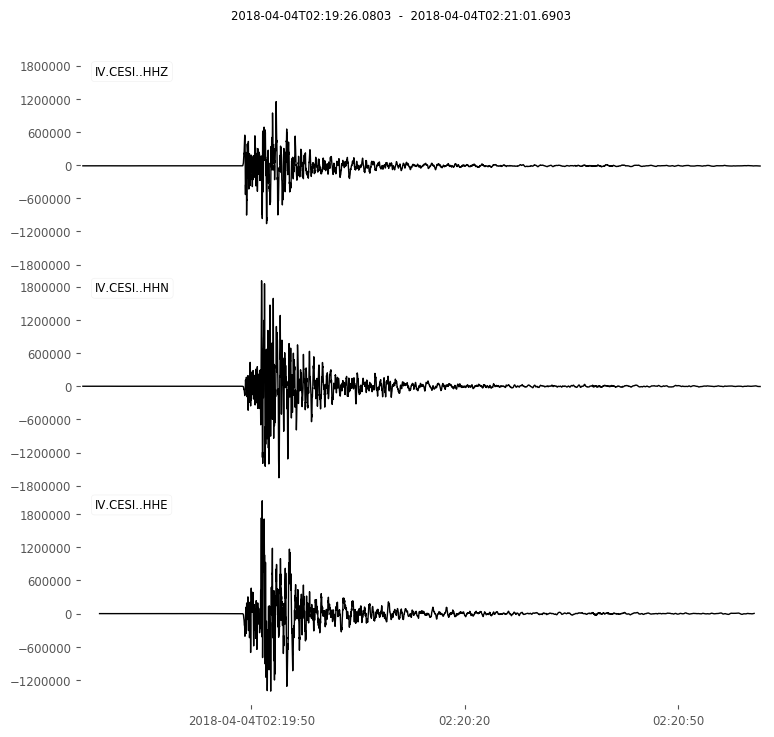

In [27]:
# Usa il metodo .plot() per una rapida visualizzazione 
# del contenuto dello stream.
st.plot()

1 Trace(s) in Stream:
IV.CESI..HHZ | 2018-04-04T02:19:26.190300Z - 2018-04-04T02:21:01.560300Z | 100.0 Hz, 9538 samples


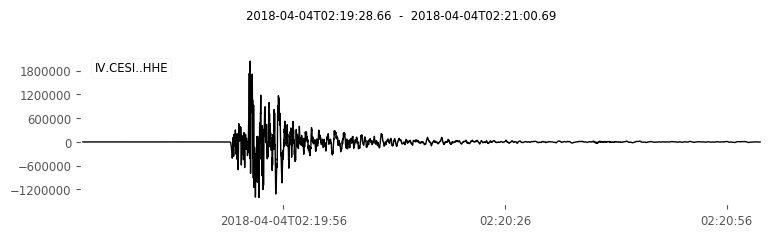

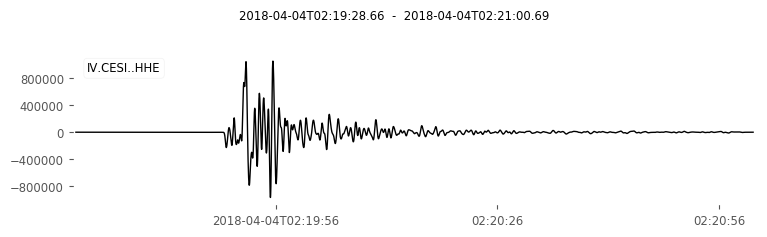

In [30]:
# Qui vedremo brevemente come lavorare con gli oggetti Stream/Trace.

# La maggior parte delle operazioni modifica gli oggetti esistenti. 
# Questo viene fatto per motivi di prestazioni.

# Creiamo quindi una copia dello stream in modo che le esecuzioni multiple di questa cella di notebook 
# non vadano a modificare i dati originali.
st2 = st.copy()

# Per usare solo parte dello stream, usare la funzione select(). In questo caso solo la componente Z
print(st2.select(component="Z"))

# Gli oggetti Stream si comportano come una lista di oggetti Trace. 
# In questo caso tr è la prima traccia dello stream st2
tr = st2[0]

# Il plot funziona anche per le singole tracce.
tr.plot()

# Alcune azioni di processamento dati. Notate che queste operazioni modificano 
# il file esistente. 
tr.detrend("linear")
tr.taper(type="hann", max_percentage=0.05)
tr.filter("lowpass", freq=2.0, corners=4)

# Ripetere il Plot.
tr.plot()

In [31]:
# È possibile scrivere il file semplicemente specificando il formato.
st.write("temp.mseed", format="mseed")

## Station Data

![inv](images/Inventory.svg)

I dati della stazione contengono informazioni sull'organizzazione che raccoglie i dati, le informazioni geografiche e la risposta dello strumento. Principalmente disponibili in tre formati:

* `(dataless)SEED`: formato binario completo ma molto complesso. Ancora usato molto, ad es. per il protocollo Arclink
* `RESP`: Un sottoinsieme ristretto di SEED. Basato su ASCII. Contiene **SOLO** la risposta dello strumento. 
* `StationXML`: Essenzialmente come SEED ma più pulito e basato su XML. È il formato più moderno e ciò che i data center oggi forniscono. **Se puoi usa questo.**


ObsPy può lavorare con tutti allo stesso modo, ma in questa guida ci concentreremo su StationXML.

Questi sono file XML:

In [32]:
!head INGV/stazioni.xml

<?xml version='1.0' encoding='UTF-8'?>
<FDSNStationXML xmlns="http://www.fdsn.org/xml/station/1" schemaVersion="1.0">
  <Source>SeisNet-mysql</Source>
  <Sender>INGV-CNT</Sender>
  <Module>INGV-CNT WEB SERVICE: fdsnws-station | version: 1.1.40</Module>
  <ModuleURI>http://webservices.ingv.it/fdsnws/station/1/query?level=channel&amp;network=IV&amp;starttime=2018-04-23T14%3A39%3A02.087864</ModuleURI>
  <Created>2018-04-23T14:39:13</Created>
  <Network code="IV" restrictedStatus="open" startDate="1988-01-01T00:00:00">
    <Description>Italian Seismic Network</Description>
    <ingv:Identifier xmlns:ingv="https://raw.githubusercontent.com/FDSN/StationXML/master/fdsn-station.xsd">N1</ingv:Identifier>


In [33]:
import obspy

# Usa la funzione read_inventory per aprirli. Questa funzione
# restituirà un oggetti Inventory.
inv = obspy.read_inventory("INGV/stazioni.xml")
print(inv)

Inventory created at 2018-04-23T14:39:13.000000Z
	Created by: INGV-CNT WEB SERVICE: fdsnws-station | version: 1.1.40
		    http://webservices.ingv.it/fdsnws/station/1/query?level=channel&net...
	Sending institution: SeisNet-mysql (INGV-CNT)
	Contains:
		Networks (1):
			IV
		Stations (360):
			IV.ACER (Acerenza)
			IV.AGLI (Aglientu)
			IV.AGST (AUGUSTA)
			IV.AIO (Antillo, Italy)
			IV.ALJA (Alia)
			IV.AMUR (Altamura)
			IV.AOI (MONTE CONERO)
			IV.APEC (Apecchio)
			IV.APPI (APPIANO)
			IV.APRC (Apricena (FG))
			IV.ARCI (Arcidosso)
			IV.ARRO (Arrone)
			IV.ARVD (ARCEVIA 2)
			IV.ASOL (Asolo)
			IV.ASQU (Asqua)
			IV.ASSB (Assisi San Benedetto)
			IV.ATBU (AVT - Serra di Burano)
			IV.ATCC (AVT - Casa Castalda)
			IV.ATFO (Monte Foce - Gubbio)
			IV.ATLO (AVT - Montelovesco)
			IV.ATMC (Monte Cedrone)
			IV.ATMI (AVT - Monte Miggiano)
			IV.ATN (ANTENNAMARE)
			IV.ATPC (Poggio Castellaccio)
			IV.ATPI (Pietralunga - Aviosuperficie)
			IV.ATSC (Scheggia)
			IV.ATTE (AVT - Monte Tezi

Come puoi vedere possono contenere un numero arbitrario di reti, stazioni e canali.

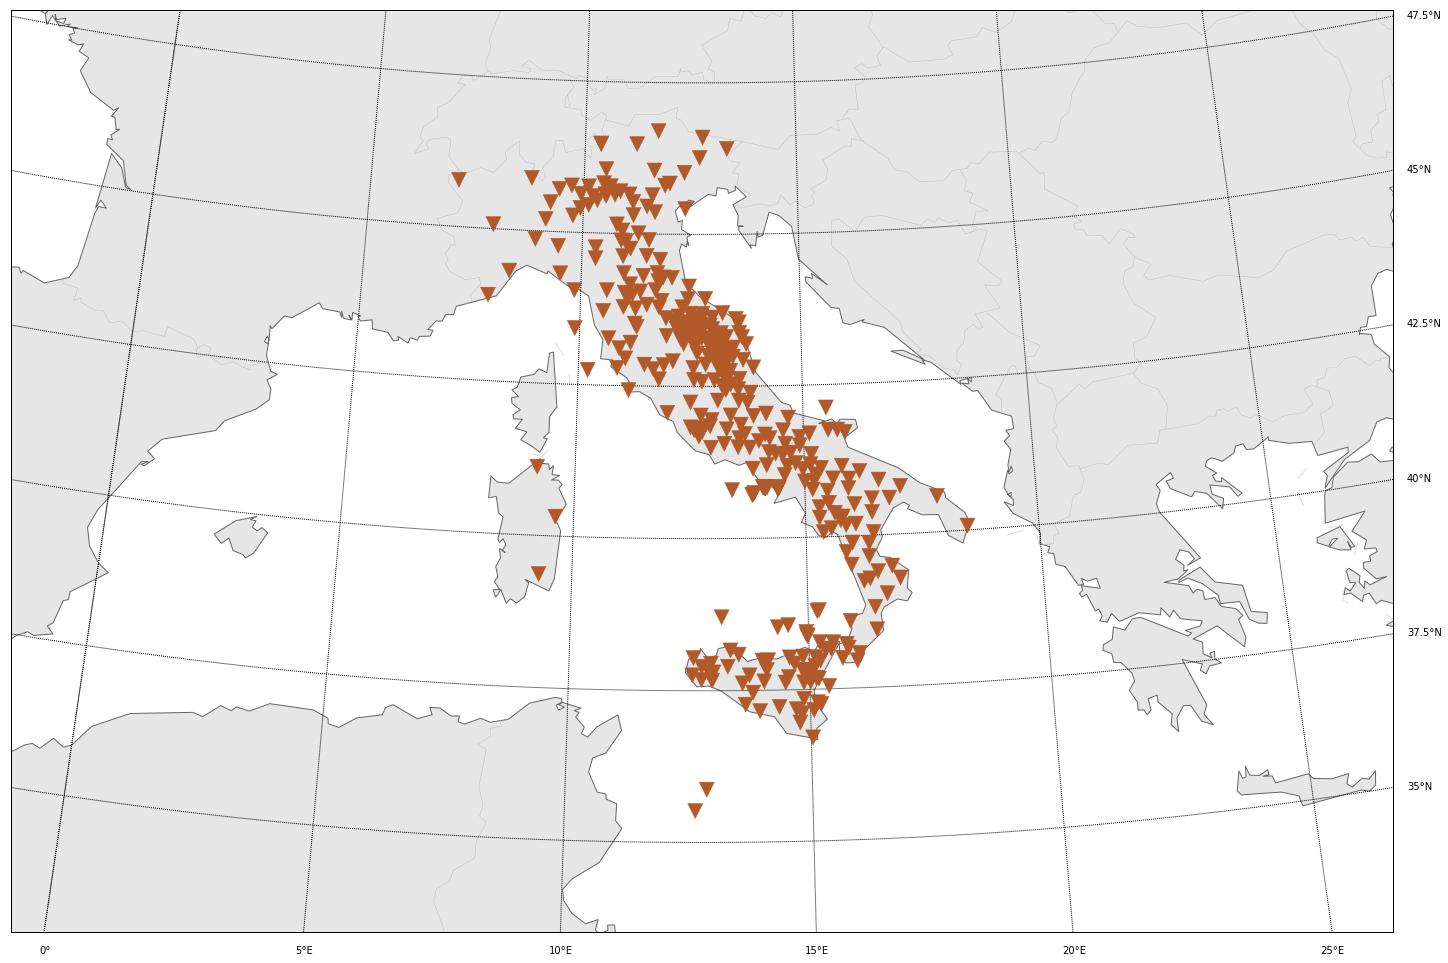

In [34]:
# Con ObsPy è possibile metterli su una mappa.
inv.plot(projection="local");

In [35]:
# È possibile anche estrarre le coordinate dei singoli canali. 
# Questa funzione accetta anche argomenti datetime per estrarre 
# informazioni in diversi momenti nel tempo.
inv.get_coordinates("IV.PII..HHZ")

{'elevation': 66.0,
 'latitude': 43.72193,
 'local_depth': 0.0,
 'longitude': 10.52495}

In [36]:
# E naturalmente può essere scritta di nuovo, anche in uno stato modificato.
inv.select(channel="BHZ").write("temp.xml", format="stationxml")

## Event Data

![events](./images/Event.svg)

I dati degli eventi sono spesso forniti in formati molto semplici come NDK o il formato CMTSOLUTION utilizzato da molti solutori di forme d'onda:

In [37]:
!cat data/GCMT_2014_08_24__Mw_6_1

 PDEW2014  8 24 10 20 44.10  38.2200 -122.3100  11.2 0.0 6.1 NORTHERN CALIFORNIA
event name:     201408241020A
time shift:      5.2600
half duration:   2.6000
latitude:       38.3100
longitude:    -122.3800
depth:          12.0000
Mrr:      -4.760000e+23
Mtt:      -1.090000e+25
Mpp:       1.140000e+25
Mrt:      -1.360000e+24
Mrp:      -2.500000e+24
Mtp:       1.120000e+25


Datacenters forniscono file **QuakeML**, che sono sorprendentemente complessi per quanto riguarda la loro struttura ma possono contenere relazioni dettagliate tra parti di dati.

In [38]:
# Leggi i file QuakeML con la funzione read_events().
cat = obspy.read_events("INGV/tirreno_eq.xml")
print(cat)

1 Event(s) in Catalog:
2018-04-23T09:28:47.460000Z | +38.809,  +13.772 | 3.6 ML | manual


In [39]:
print(cat[0])

Event:	2018-04-23T09:28:47.460000Z | +38.809,  +13.772 | 3.6 ML | manual

	            resource_id: ResourceIdentifier(id="smi:webservices.ingv.it/fdsnws/event/1/query?eventId=18972731")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='INGV', author='hew10_mole#MOD_EQASSEMBLE', creation_time=UTCDateTime(2018, 4, 23, 9, 28, 22))
	    preferred_origin_id: ResourceIdentifier(id="smi:webservices.ingv.it/fdsnws/event/1/query?originId=55995051")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:webservices.ingv.it/fdsnws/event/1/query?magnitudeId=57085801")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


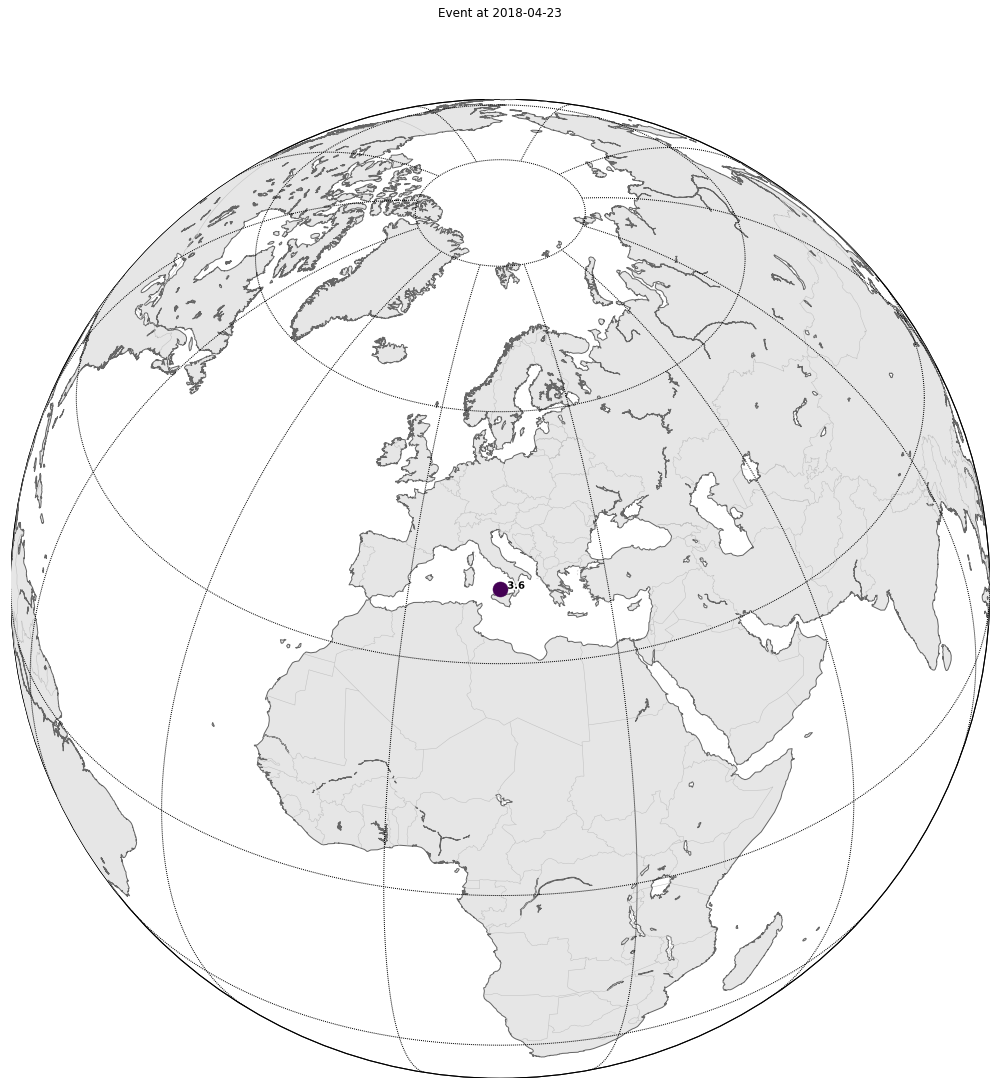

In [40]:
cat.plot(projection="ortho");

In [41]:
# Ancora ua volta possono essere riscritti con la funzione write().
cat.write("temp_quake.xml", format="quakeml")

Per mostrare altre cose, ho aggiunto un file contenente tutti gli eventi che l'INGV ha localizzato in un raggio di 50 km intorno a Lucca a partire dal 2010 con magnitudo uguale a 2 o superiore.

In [42]:
import obspy

cat = obspy.read_events("./INGV/lucca.xml")

print(cat)

703 Event(s) in Catalog:
2010-01-14T16:29:35.570000Z | +43.518,  +10.531 | 2.1 ML | manual
2010-02-03T18:18:47.820000Z | +44.130,  +10.880 | 2.1 ML | manual
...
2018-01-31T07:09:16.930000Z | +43.941,  +10.303 | 2.1 ML | manual
2018-03-24T21:01:58.680000Z | +44.080,  +10.822 | 2.4 ML | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


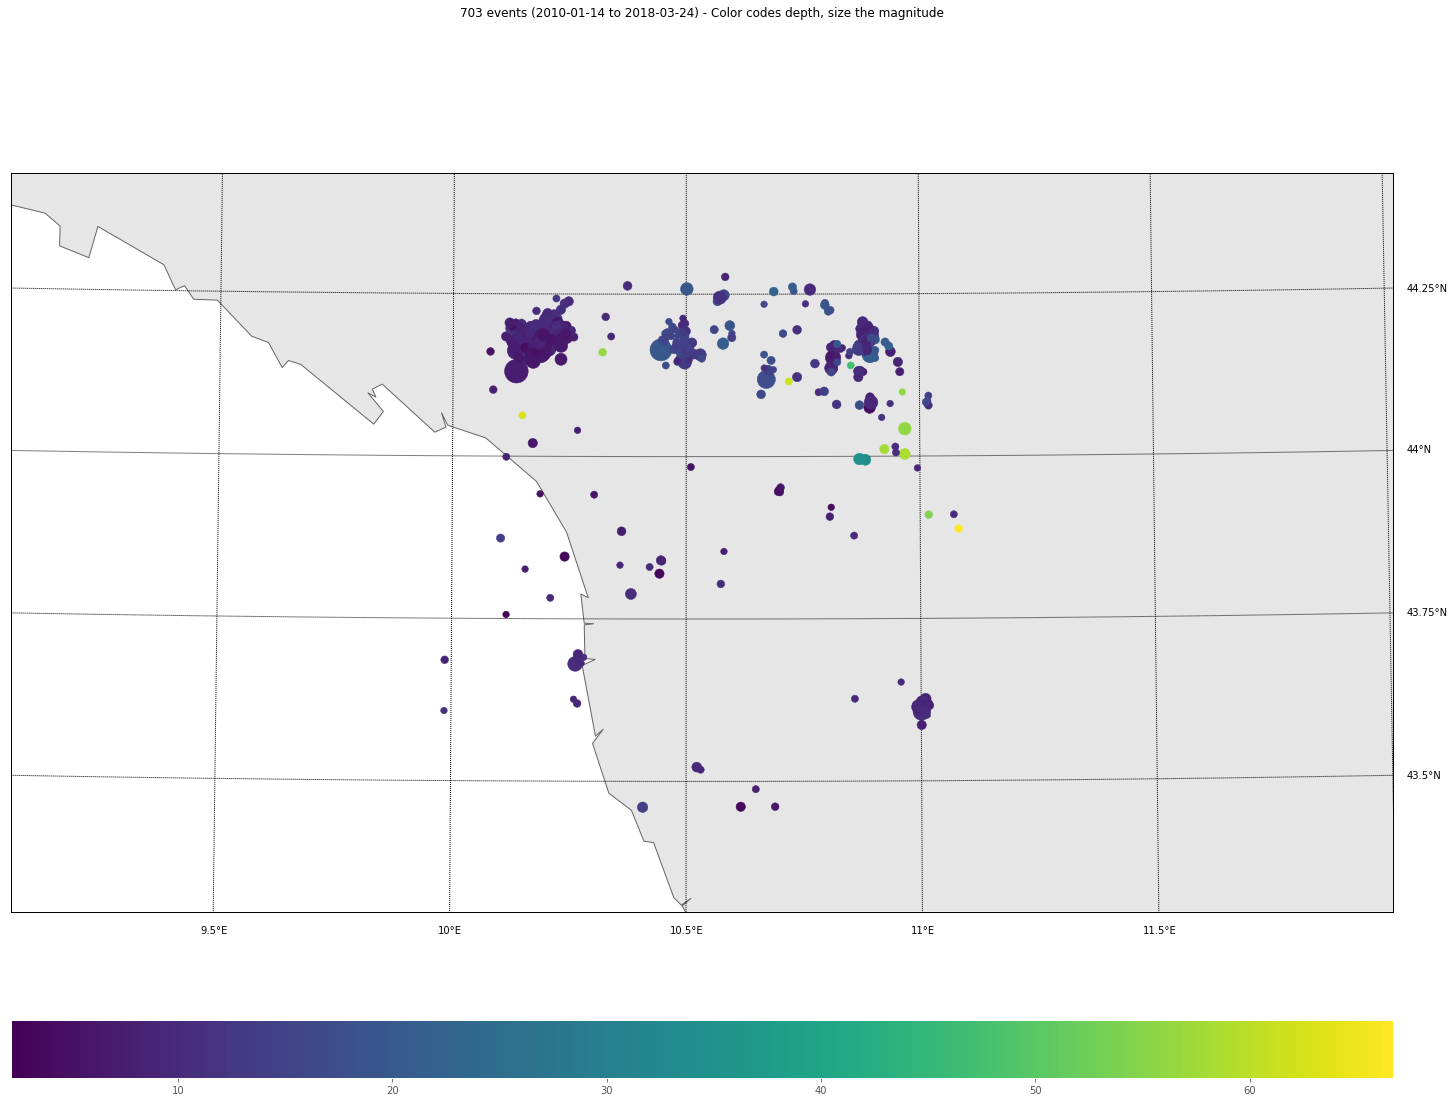

In [43]:
cat.plot(projection="local", resolution="i");

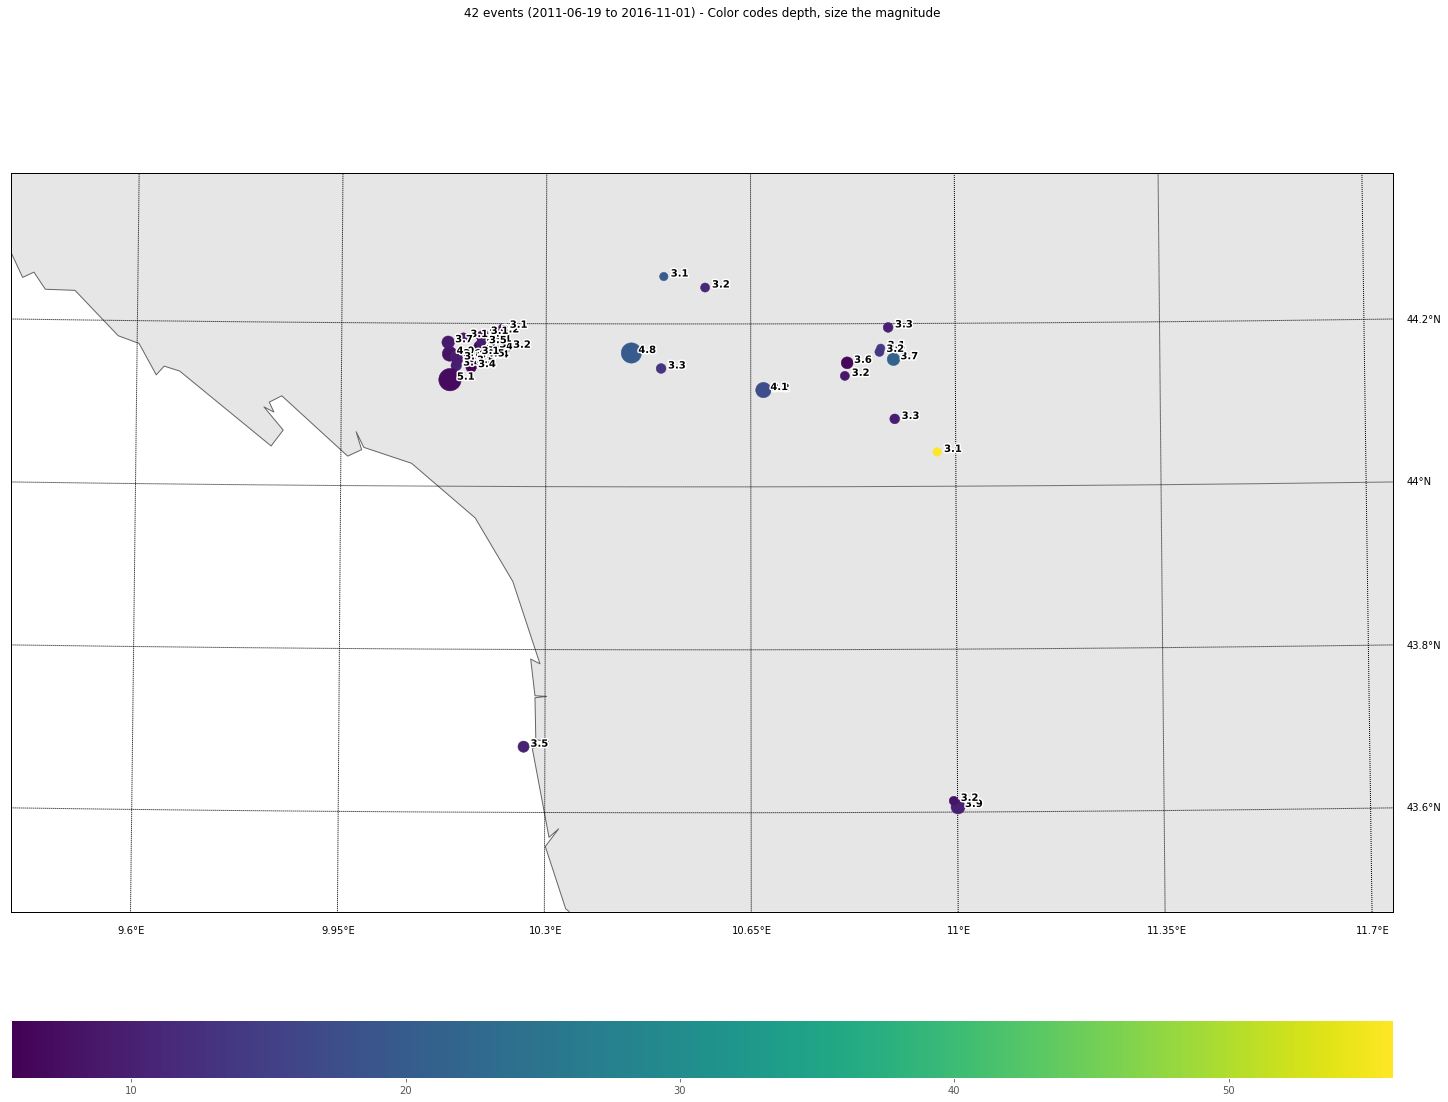

In [44]:
cat.filter("magnitude > 3").plot(projection="local", resolution="i");